In [10]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

from importlib import reload

from matplotlib.patches import Rectangle

import lina


In [11]:
reload(cscoob)
reload(dm)
model = cscoob.SCOOB(npix=256, oversample=4, psf_pixelscale_lamD=1/3.05, dm_fill_factor=0.94)

Using default Gaussian influence function.
Using reflection when computing OPD.


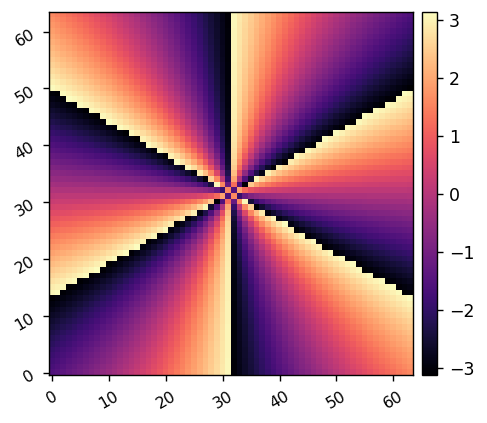

8.0


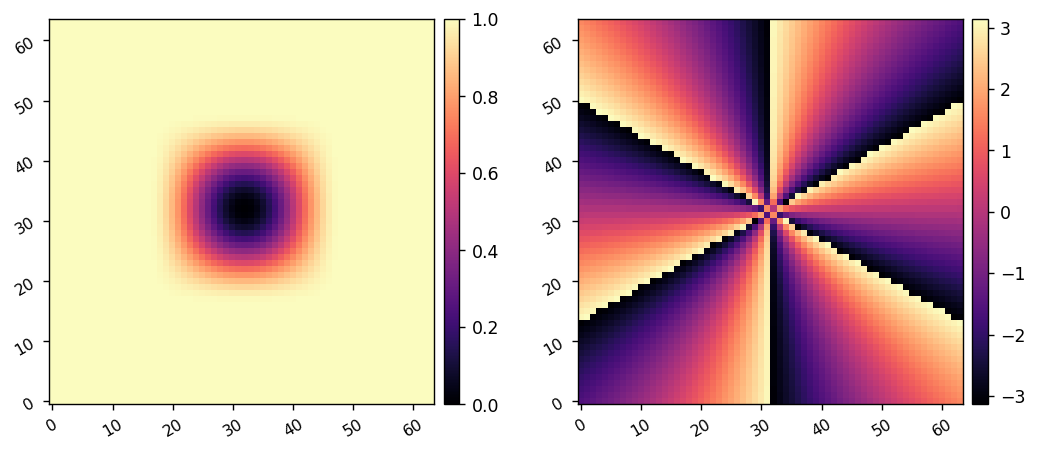

In [12]:
from scipy.signal import windows

window_size = 32

focal_pixelscale_lamD = 1/model.oversample
x_fp = ( xp.linspace(-model.N/2, model.N/2-1, model.N) + 1/2 ) * focal_pixelscale_lamD
fpx, fpy = xp.meshgrid(x_fp, x_fp)
focal_grid = xp.array([xp.sqrt(fpx**2 + fpy**2), xp.arctan2(fpy,fpx)])

vortex = cscoob.make_vortex_phase_mask(focal_grid, charge=6, )
imshow1(xp.angle(vortex), npix=64)

wx = xp.array(windows.tukey(window_size, 1, False))
wy = xp.array(windows.tukey(window_size, 1, False))
w = xp.outer(wy, wx)
w = xp.pad(w, (focal_grid[0].shape[0] - w.shape[0]) // 2, 'constant')
vortex *= 1 - w

print(focal_pixelscale_lamD*32)

imshow2(1-w, xp.angle(vortex),npix=64)

In [105]:
from matplotlib.patches import Rectangle

# test a basic MFT


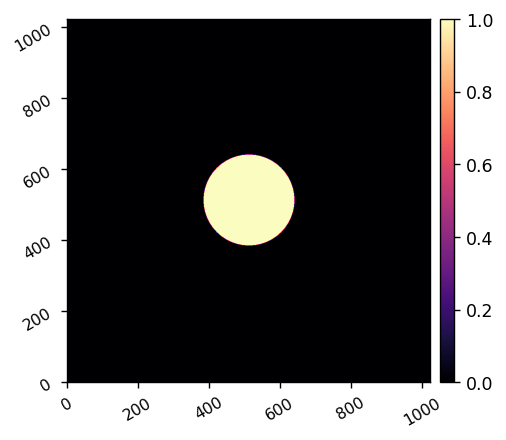

In [5]:
imshow1(model.PUPIL)

32.0


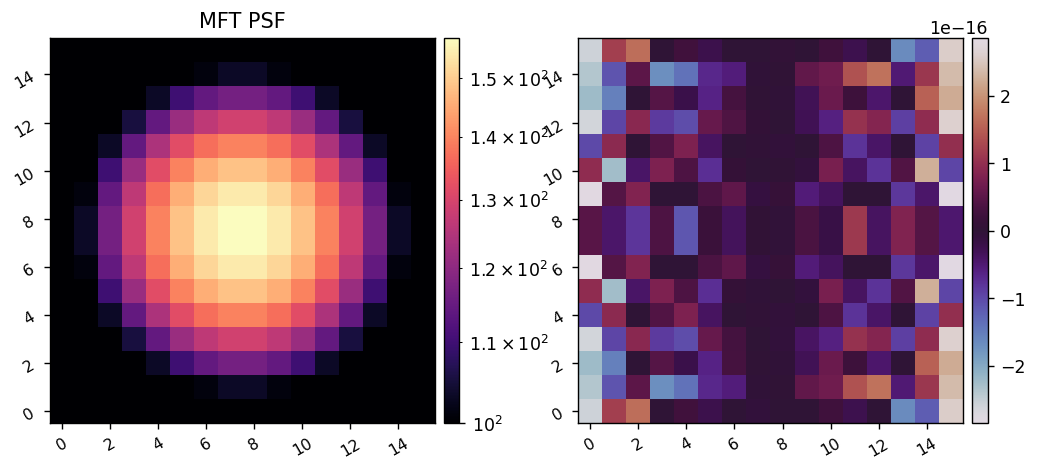

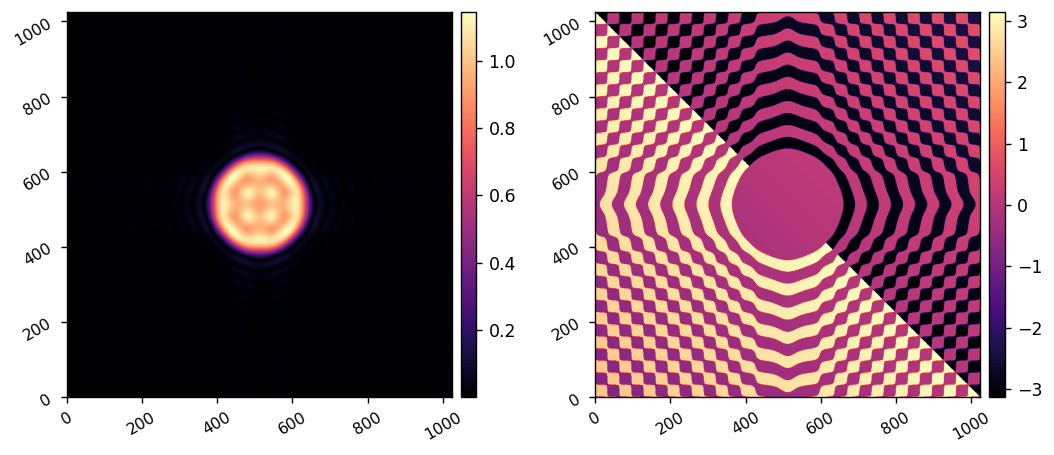

In [6]:

npix = model.npix
oversample = model.oversample
N = model.N

nmft = 128
mft_pixelscale_lamD = 0.0625
nlamD = nmft * mft_pixelscale_lamD * oversample
print(nlamD)

fpwf = cscoob.mft(model.PUPIL, nlamD, nmft)
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), f'MFT PSF', npix=16, lognorm1=True, vmin1=1e2, cmap2='twilight')

E_pup = cscoob.mft(fpwf, nlamD, N, forward=False, centering='FFTSTYLE')
imshow2(xp.abs(E_pup), xp.angle(E_pup),)

In [7]:
def apply_vortex(pupil_wavefront, Nprops=4, window_size=32, nmft=128):

        for i in range(Nprops):
            if i==0: # this is the generic FFT step
                print('Initial FFT propagation:')
                focal_pixelscale_lamD = 1/oversample
                x_fp = ( xp.linspace(-N/2, N/2-1, N) ) * focal_pixelscale_lamD
                fpx, fpy = xp.meshgrid(x_fp, x_fp)
                focal_grid = xp.array([xp.sqrt(fpx**2 + fpy**2), xp.arctan2(fpy,fpx)])

                vortex = cscoob.make_vortex_phase_mask(focal_grid, charge=6, )

                wx = xp.array(windows.tukey(window_size, 1, False))
                wy = xp.array(windows.tukey(window_size, 1, False))
                w = xp.outer(wy, wx)
                w = xp.pad(w, (focal_grid[0].shape[0] - w.shape[0]) // 2, 'constant')
                vortex *= 1 - w
                imshow2(1-w, xp.angle(vortex),npix=nmft)
                
                # take fft of pupil wavefront
                fpwf = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(pupil_wavefront)))
                corner = (-window_size*focal_pixelscale_lamD/2, -window_size*focal_pixelscale_lamD/2)
                length = window_size*focal_pixelscale_lamD
                imshow2(xp.abs(fpwf), xp.angle(fpwf), 'FFT PSF', npix=nmft, lognorm1=True, pxscl=focal_pixelscale_lamD, 
                        patches1=[Rectangle(corner, length, length, fill=False)])

                # apply the windowed vortex
                fpwf *= vortex

                # take the inverse FFT to go back to the pupil plane
                E_pup = xp.fft.ifftshift(xp.fft.ifft2(fpwf))
                imshow2(xp.abs(E_pup), xp.angle(E_pup), 'FFT Pupil', lognorm1=True)

                E_LS = E_pup

                next_pixelscale = window_size*focal_pixelscale_lamD/nmft # for the next propagation iteration
            else: # this will handle the MFT stages
                print(f'MFT propagation {i}')

                mft_pixelscale_lamD = next_pixelscale
                nlamD = nmft * mft_pixelscale_lamD * oversample
                print(mft_pixelscale_lamD, nlamD/oversample)

                # x_fp = ( xp.linspace(-nmft/2, nmft/2-1, nmft) + 1/2 ) * mft_pixelscale_lamD
                x_fp = ( xp.linspace(-nlamD/2, nlamD/2, nmft))
                fpx, fpy = xp.meshgrid(x_fp, x_fp)
                focal_grid = xp.array([xp.sqrt(fpx**2 + fpy**2), xp.arctan2(fpy,fpx)])

                vortex = cscoob.make_vortex_phase_mask(focal_grid, charge=6, )

                wx = xp.array(windows.tukey(window_size, 1, False))
                wy = xp.array(windows.tukey(window_size, 1, False))
                w = xp.outer(wy, wx)
                w = xp.pad(w, (focal_grid[0].shape[0] - w.shape[0]) // 2, 'constant')
                vortex *= 1 - w
                imshow2(1-w, xp.angle(vortex))

                # take the MFT of the pupil_wavefront
                fpwf = cscoob.mft(pupil_wavefront, nlamD, nmft, forward=True, )
                # fpwf = cscoob.mft(E_LS, nlamD, nmft, forward=True, centering='FFTSTYLE')
                corner = (-window_size*mft_pixelscale_lamD/2, -window_size*mft_pixelscale_lamD/2)
                length = window_size*mft_pixelscale_lamD
                imshow2(xp.abs(fpwf), xp.angle(fpwf), f'MFT {i} PSF', npix=nmft, lognorm1=True, pxscl=mft_pixelscale_lamD, 
                        patches1=[Rectangle(corner, length, length, fill=False)])
                
                # apply the windowed vortex
                if i!=Nprops-1:
                    fpwf *= vortex
                
                # take the inverse MFT to go back to the pupil plane
                E_pup = cscoob.mft(fpwf, nlamD, N, forward=False, )
                imshow2(xp.abs(E_pup), xp.angle(E_pup), f'MFT {i} Pupil', lognorm1=True)
                
                # adjust the pixelscale for the next iteration of propagation
                next_pixelscale = window_size*mft_pixelscale_lamD/nmft # for the next propagation iteration

                # add the new pupil wavefront to the total pupil wavefront
                E_LS += E_pup
            
        return E_LS

Initial FFT propagation:


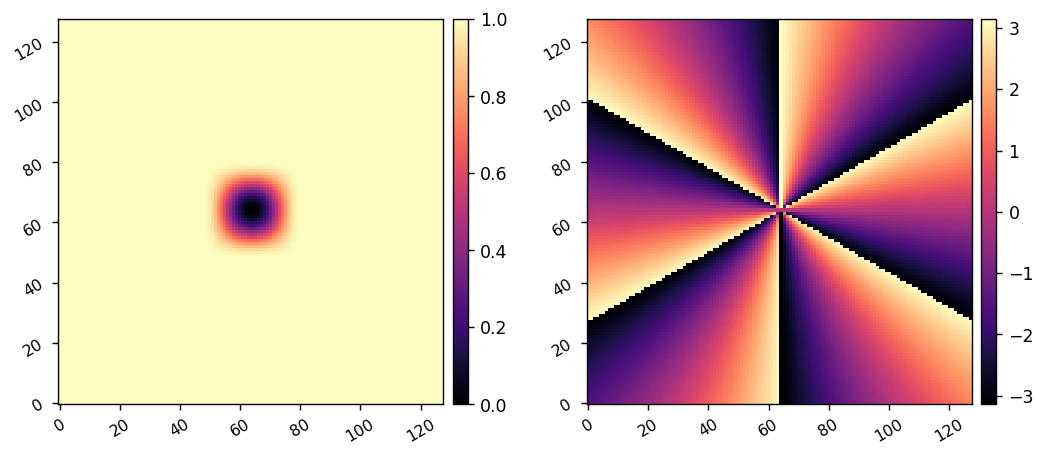

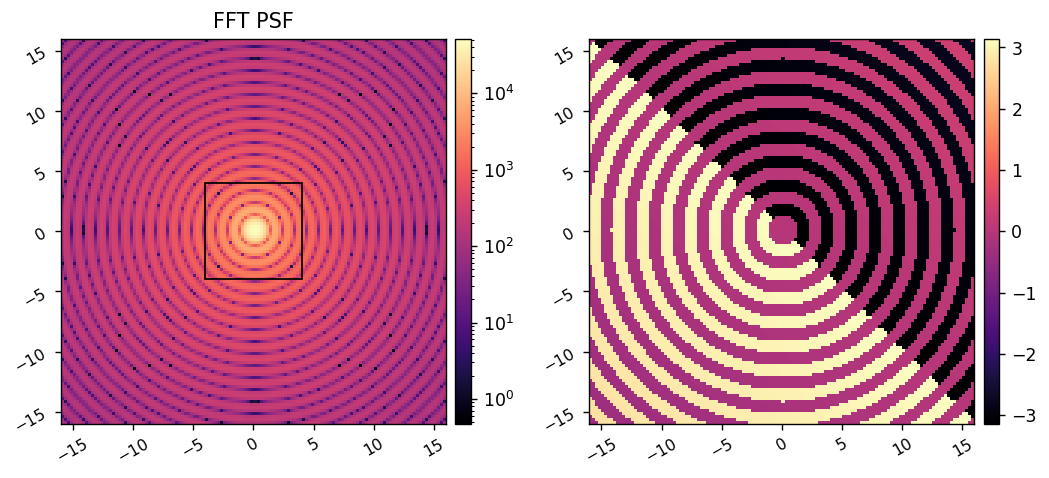

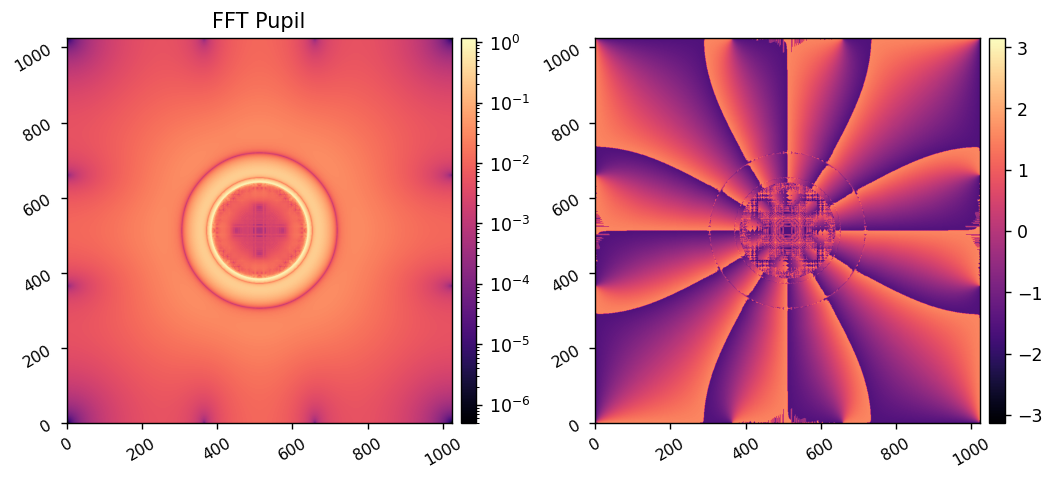

MFT propagation 1
0.0625 8.0


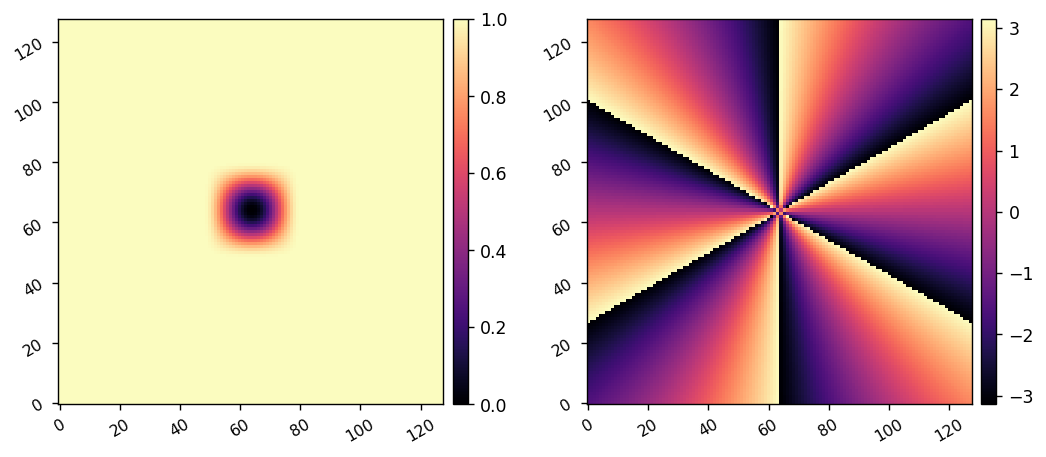

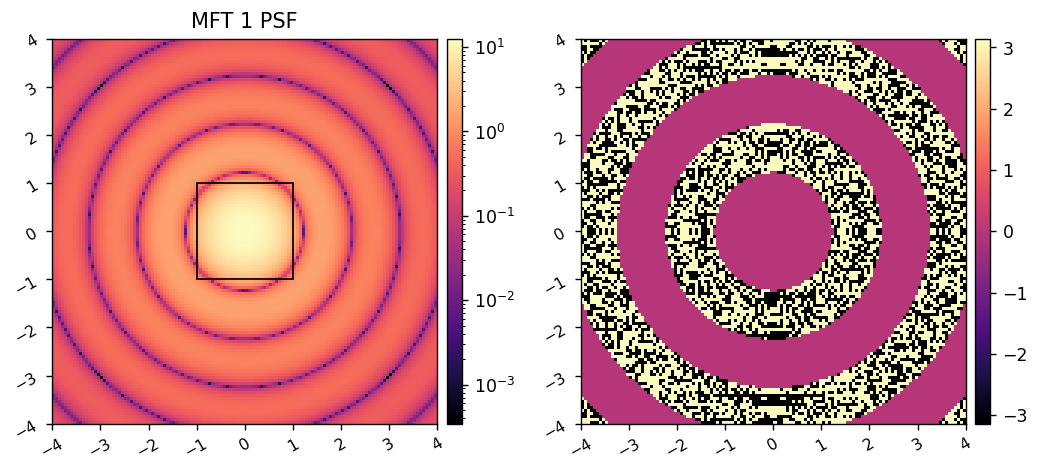

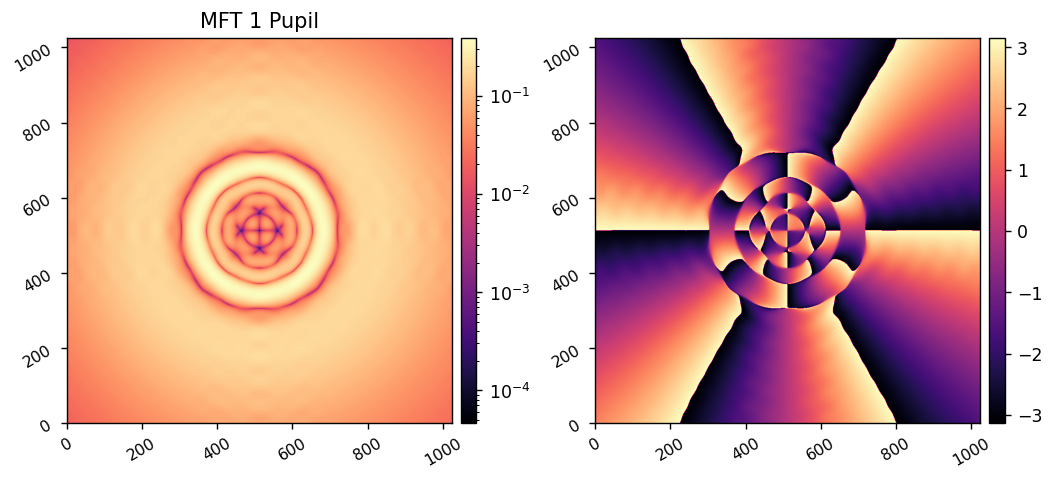

MFT propagation 2
0.015625 2.0


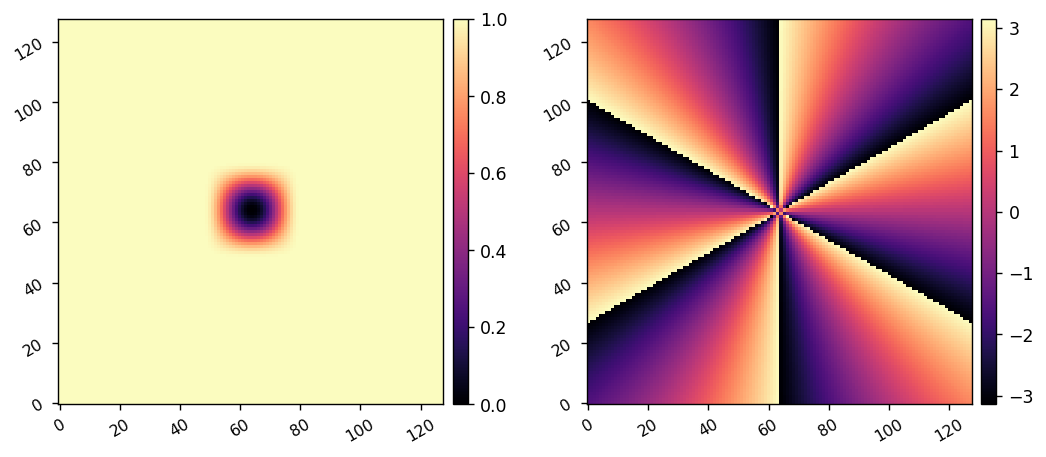

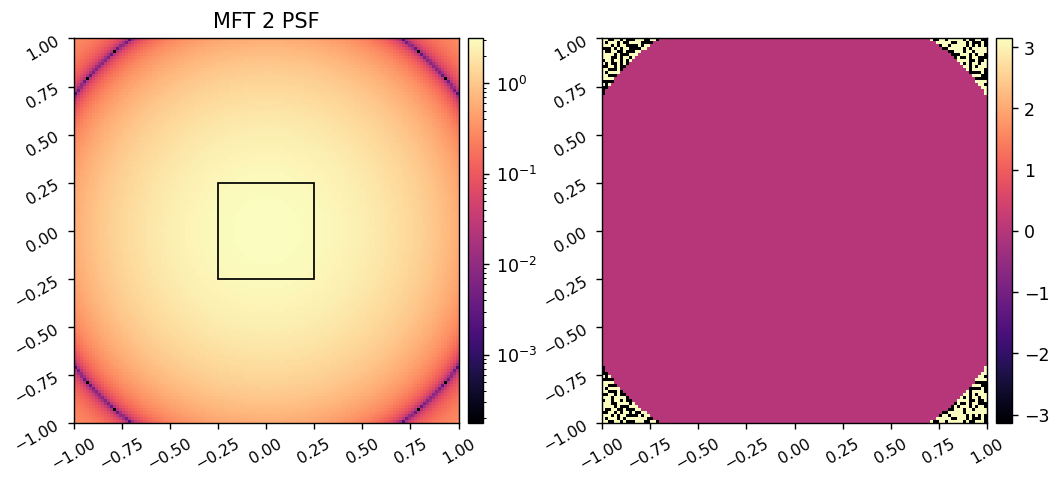

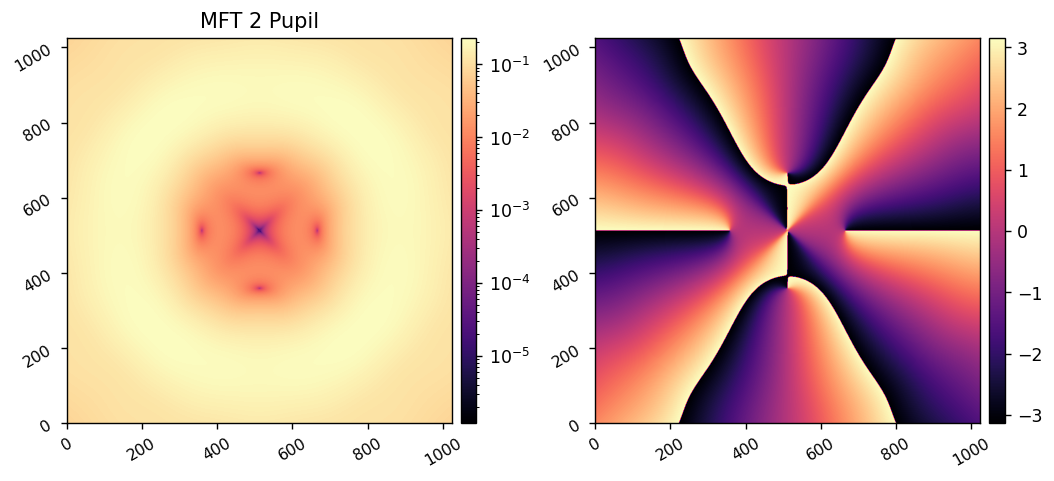

MFT propagation 3
0.00390625 0.5


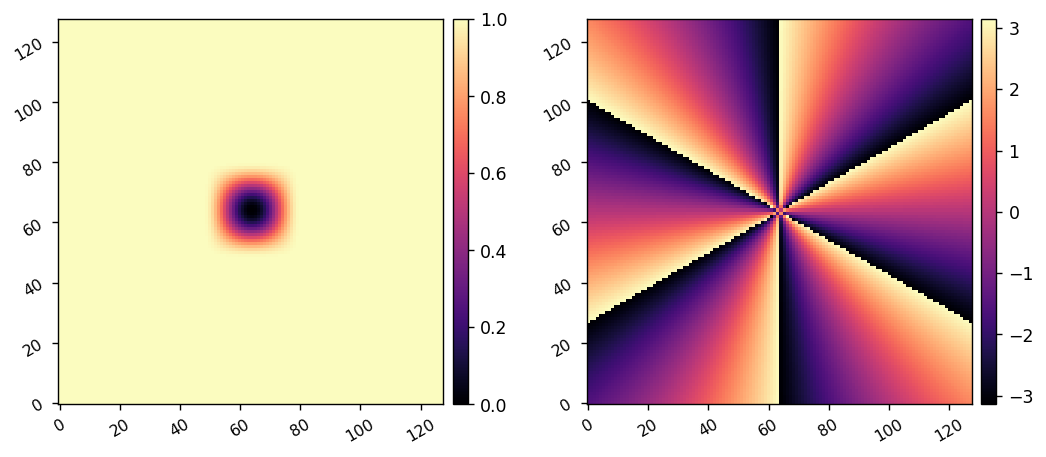

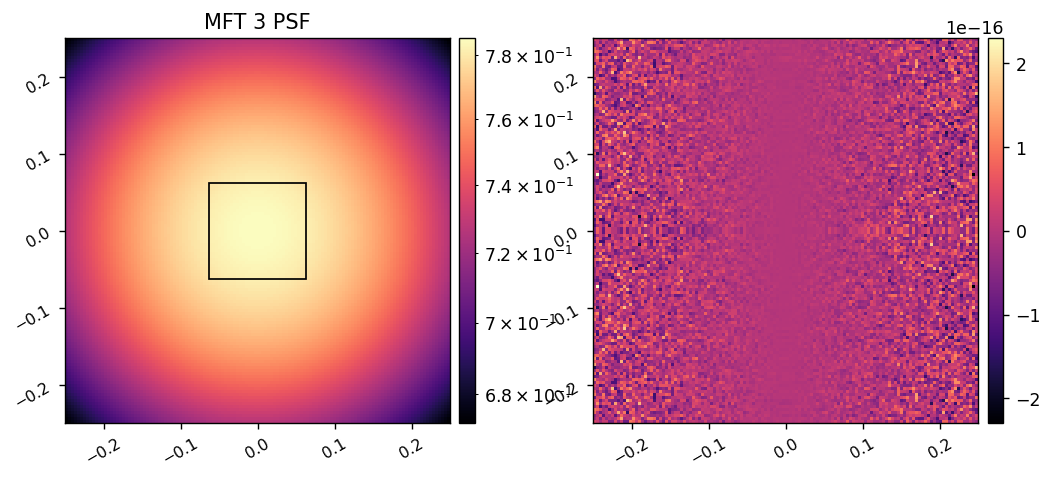

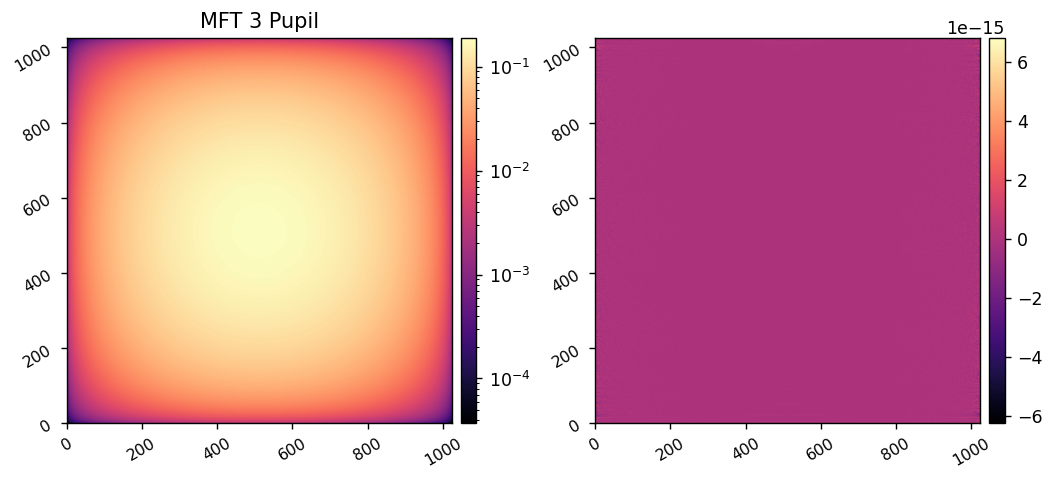

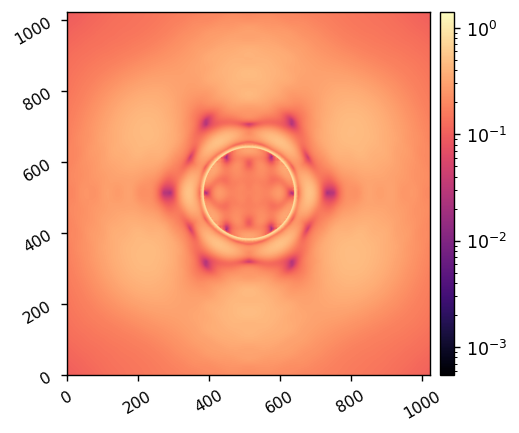

In [13]:


E_LS = apply_vortex(model.PUPIL, Nprops=4, window_size=32)
imshow1(xp.abs(E_LS), lognorm=True)

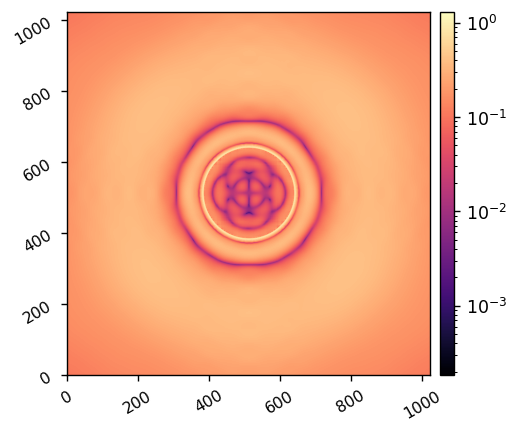

128.0


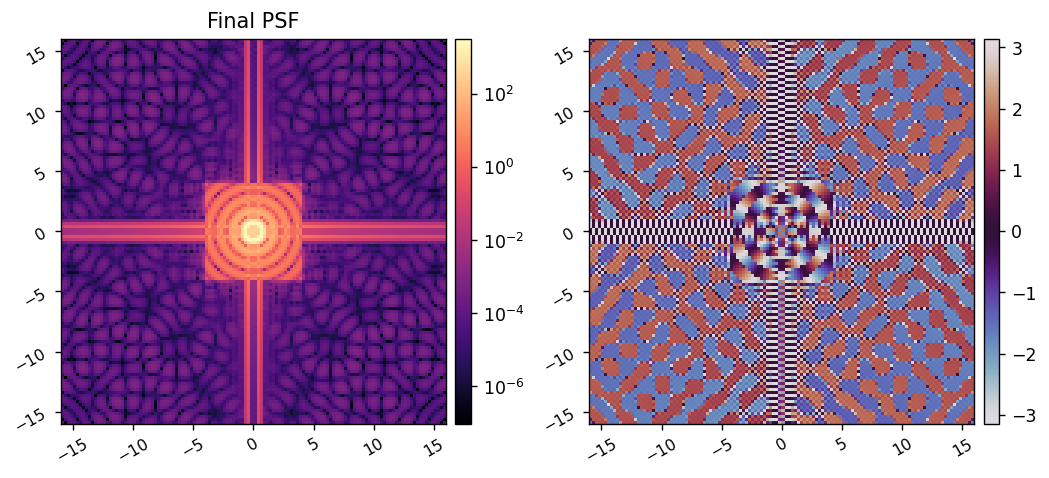

In [122]:
imshow1(xp.abs(E_LS), lognorm=True)

nmft = 128
mft_pixelscale_lamD = 1/4
print(nlamD)

nlamD = nmft * mft_pixelscale_lamD * oversample
fpwf = cscoob.mft(E_LS, nlamD, nmft)
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), f'Final PSF', npix=nmft, lognorm1=True, cmap2='twilight', 
        pxscl=mft_pixelscale_lamD)
